In [1]:
import numpy as np
import keras
import tensorflow as tf
import effector
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

/Users/dimitriskyriakopoulos/Documents/ath/Effector/Code/eff-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(21)

In [3]:
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [4]:
feature_names = california_housing.feature_names
target_name= california_housing.target_names[0]
df = type(california_housing.frame)

In [5]:
X = california_housing.data
y = california_housing.target

In [6]:
print("Design matrix shape: {}".format(X.shape))
print("---------------------------------")
for col_name in X.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(X[col_name].unique()), X[col_name].mean(), X[col_name].std(), X[col_name].min(), X[col_name].max()))
    
print("\nTarget shape: {}".format(y.shape))
print("---------------------------------")
print("Target: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(y.name, len(y.unique()), y.mean(), y.std(), y.min(), y.max()))

Design matrix shape: (20640, 8)
---------------------------------
Feature: MedInc         , unique: 12928, Mean:   3.87, Std:   1.90, Min:   0.50, Max:  15.00
Feature: HouseAge       , unique:   52, Mean:  28.64, Std:  12.59, Min:   1.00, Max:  52.00
Feature: AveRooms       , unique: 19392, Mean:   5.43, Std:   2.47, Min:   0.85, Max: 141.91
Feature: AveBedrms      , unique: 14233, Mean:   1.10, Std:   0.47, Min:   0.33, Max:  34.07
Feature: Population     , unique: 3888, Mean: 1425.48, Std: 1132.46, Min:   3.00, Max: 35682.00
Feature: AveOccup       , unique: 18841, Mean:   3.07, Std:  10.39, Min:   0.69, Max: 1243.33
Feature: Latitude       , unique:  862, Mean:  35.63, Std:   2.14, Min:  32.54, Max:  41.95
Feature: Longitude      , unique:  844, Mean: -119.57, Std:   2.00, Min: -124.35, Max: -114.31

Target shape: (20640,)
---------------------------------
Target: MedHouseVal    , unique: 3842, Mean:   2.07, Std:   1.15, Min:   0.15, Max:   5.00


In [7]:
def preprocess(X, y):
    # Compute mean and std for outlier detection
    X_mean = X.mean()
    X_std = X.std()
    
    # Exclude instances with any feature 2 std away from the mean
    mask = (X - X_mean).abs() <= 2 * X_std
    mask = mask.all(axis=1)
    
    X_filtered = X[mask]
    y_filtered = y[mask]

    # Standardize X
    X_mean = X_filtered.mean()
    X_std = X_filtered.std()
    X_standardized = (X_filtered - X_mean) / X_std

    # Standardize y
    y_mean = y_filtered.mean()
    y_std = y_filtered.std()
    y_standardized = (y_filtered - y_mean) / y_std

    return X_standardized, y_standardized, X_mean, X_std, y_mean, y_std



# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(X, y)

In [8]:
def split(X_df, Y_df):
    # shuffle indices
    indices = np.arange(len(X_df))
    np.random.shuffle(indices)
    
    # data split
    train_size = int(0.8 * len(X_df))
    
    X_train = X_df.iloc[indices[:train_size]]
    Y_train = Y_df.iloc[indices[:train_size]]
    X_test = X_df.iloc[indices[train_size:]]
    Y_test = Y_df.iloc[indices[train_size:]]
    
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)

In [9]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=1024, epochs=20, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.6138 - mae: 0.5828 - root_mean_squared_error: 0.7775
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3290 - mae: 0.4119 - root_mean_squared_error: 0.5736
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2978 - mae: 0.3914 - root_mean_squared_error: 0.5457
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2904 - mae: 0.3854 - root_mean_squared_error: 0.5389
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2771 - mae: 0.3758 - root_mean_squared_error: 0.5263
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2754 - mae: 0.3687 - root_mean_squared_error: 0.5247
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2770 - mae: 0.3762 - root_mean_squared_error: 0.5263
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2696 - mae: 0.3645 - root_mean_squared_error: 0.5192
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2522 - mae: 0.3506 - root_m

[0.2861937880516052, 0.3479985296726227, 0.5349708199501038]

In [10]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()

In [11]:
scale_y = {"mean": y_mean, "std": y_std}
scale_x_list =[{"mean": x_mean.iloc[i], "std": x_std.iloc[i]} for i in range(len(x_mean))]

In [45]:
y_limits = [-0.5, 5]
dy_limits = [-3, 3]

## Global effects

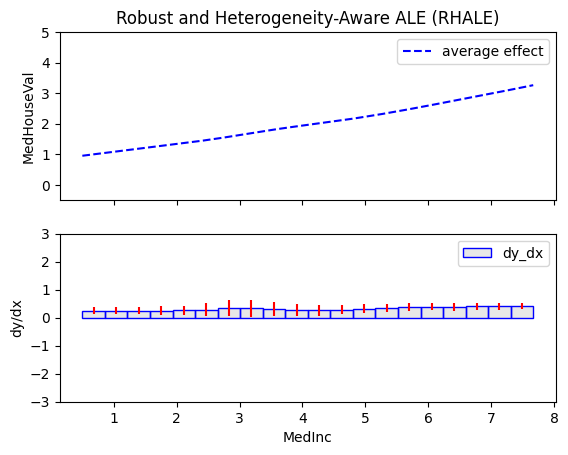

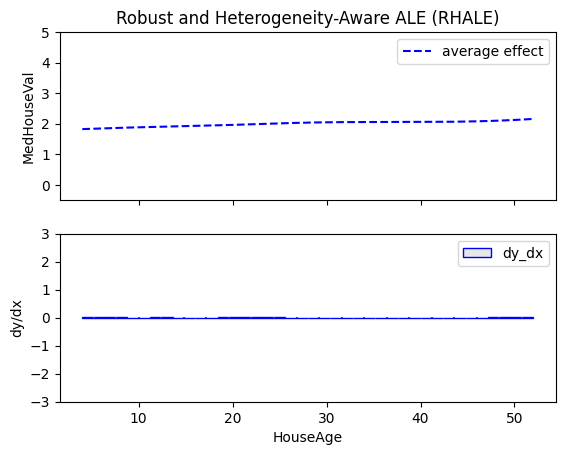

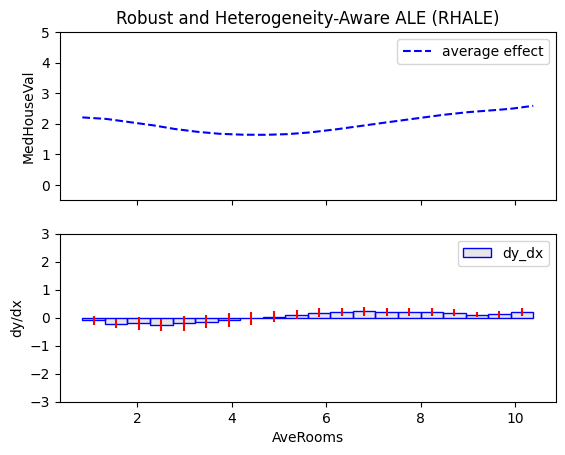

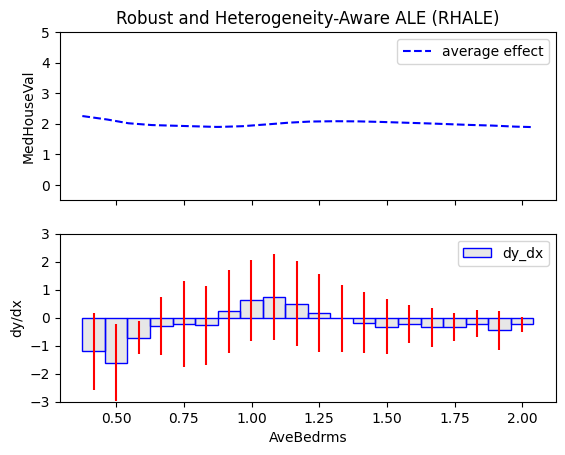

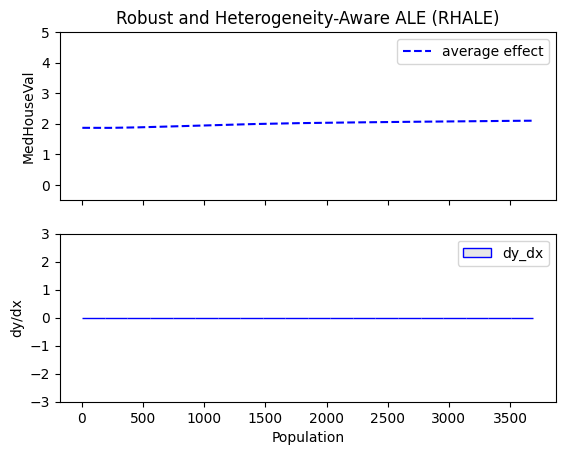

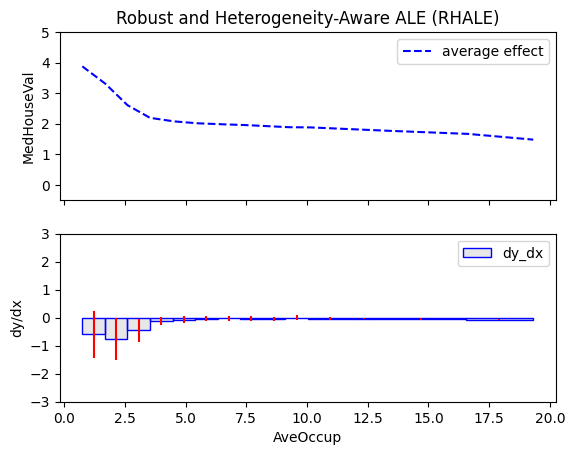

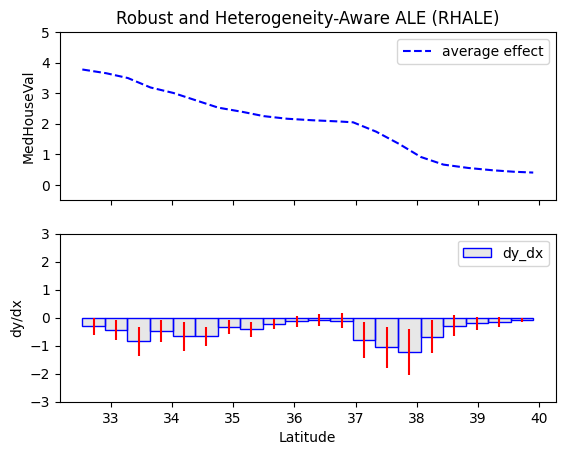

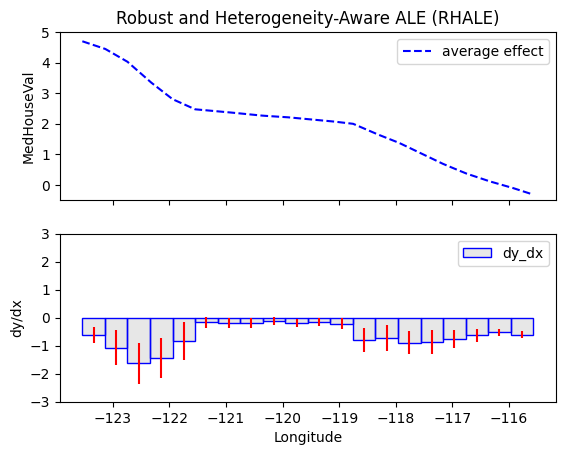

In [46]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name, nof_instances="all")
for i in range(len(feature_names)):
    rhale.plot(feature=i, centering=True, scale_x=scale_x_list[i], scale_y=scale_y, y_limits=y_limits, dy_limits=dy_limits)

## Regional Effects

In [47]:
reg_rhale = effector.RegionalRHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name, nof_instances="all")
reg_rhale.fit("all", space_partitioner=effector.space_partitioning.Best(min_heterogeneity_decrease_pcg=0.25))
reg_rhale.summary(features="all", scale_x_list=scale_x_list)

100%|██████████| 8/8 [00:18<00:00,  2.29s/it]



Feature 0 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
MedInc 🔹 [id: 0 | heter: 0.06 | inst: 14576 | w: 1.00]
--------------------------------------------------
Feature 0 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.06




Feature 1 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
HouseAge 🔹 [id: 0 | heter: 0.05 | inst: 14576 | w: 1.00]
--------------------------------------------------
Feature 1 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.05




Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
AveRooms 🔹 [id: 0 | heter: 0.04 | inst: 14576 | w: 1.00]
    MedInc ≤ 3.73 🔹 [id: 1 | heter: 0.03 | inst: 8289 | w: 0.57]
    MedInc > 3.73 🔹 [id: 2 | heter: 0.03 | inst: 6287 | w: 0.43]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.04
    Level 1🔹heter: 

**AveOccup: average number of people residing in a house**

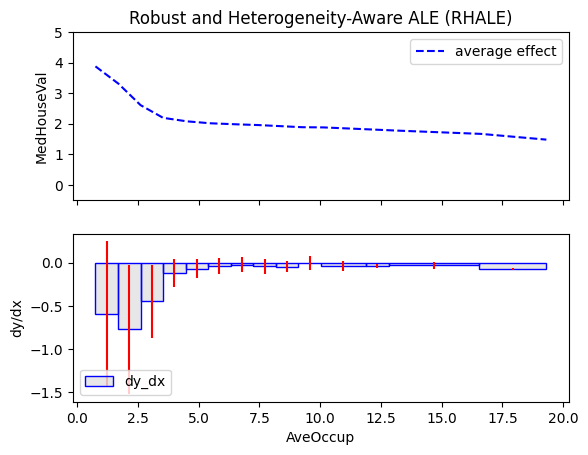

In [48]:
reg_rhale.plot(feature=5, node_idx=0, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

**Global Trend:** House prices decrease as the average number of people residing in a house increases with the highest slop in the lowest average occupancy values

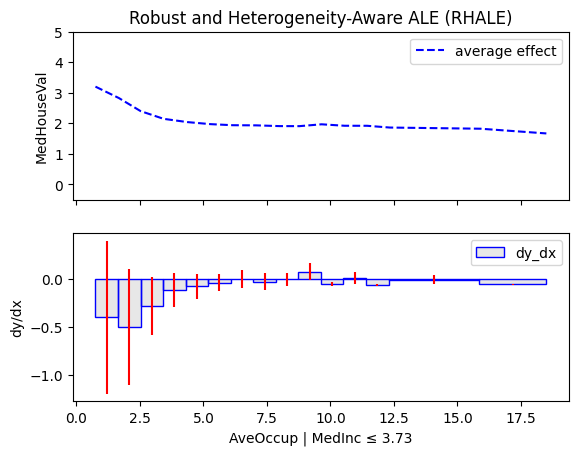

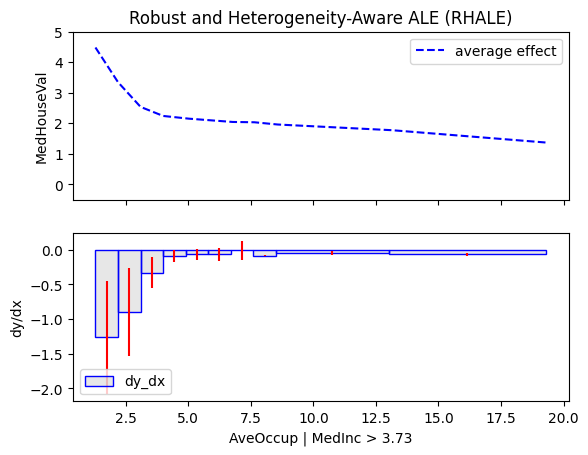

In [50]:
for node_idx in [1, 2]:
    reg_rhale.plot(feature=5, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

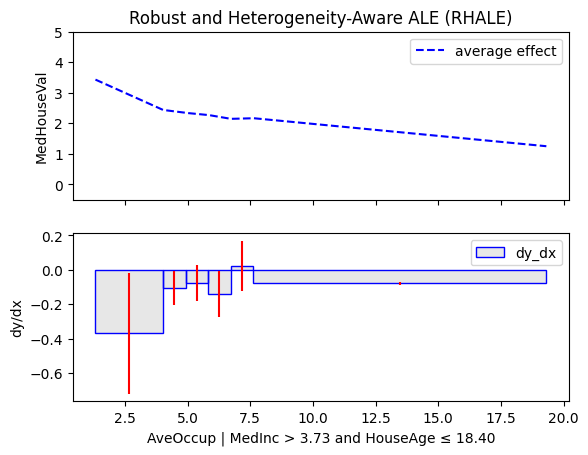

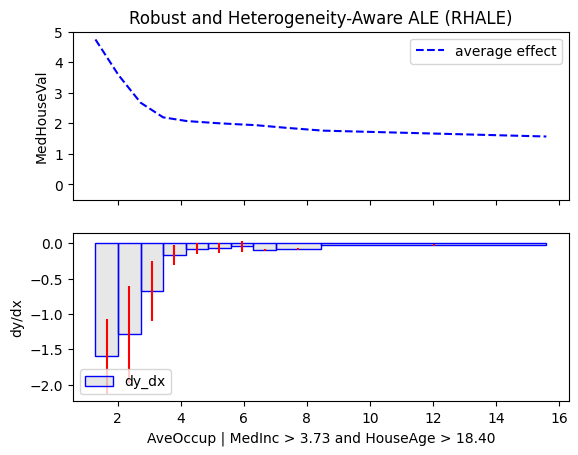

In [52]:
for node_idx in [3, 4]:
    reg_rhale.plot(feature=5, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

**Global Trend:** House prices decrease as the average number of people per household (AveOccup) increases, with the steepest drop at low occupancy levels. This suggests that even small increases in crowding can significantly reduce home values, especially in less crowded areas.

**Regional Trends:**  
- **Low-Income Areas (MedInc ≤ 3.73):** The initial slope (at low AveOccup) becomes smoother, indicating that house prices decrease more gradually with crowding in poorer regions.
- **High-Income Areas (MedInc > 3.73):** The initial slope becomes steeper, and starts from higher house values.
  - **Newer homes (HouseAge ≤ 18.40):** The slope remains smoother, starting from lower prices.
  - **Older homes (HouseAge > 18.40)** The slope becomes even steeper, and starts from higher house values, meaning older homes in high-income areas lose value rapidly as they become crowded.

## Latitude (south to north)

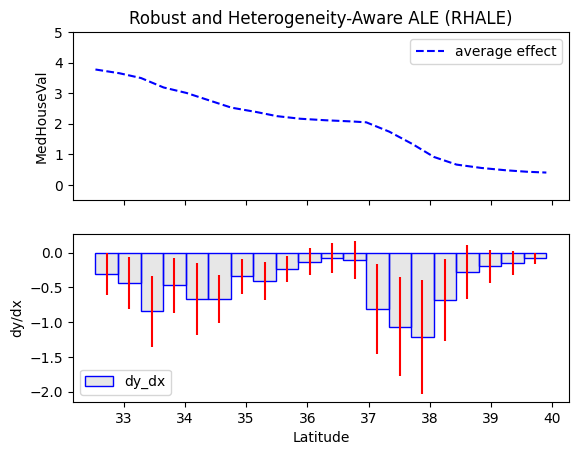

In [53]:
reg_rhale.plot(feature=6, node_idx=0, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

**Global Trend:** House prices decrease as we move north.  

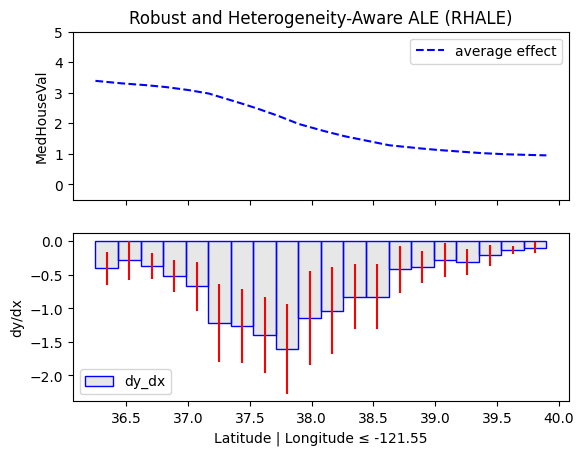

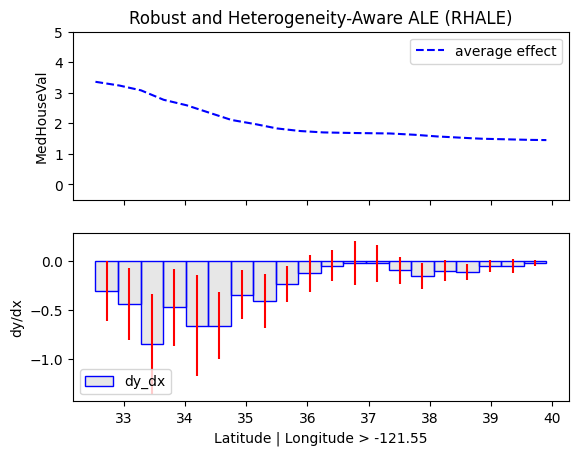

In [54]:
for node_idx in [1, 2]:
    reg_rhale.plot(feature=6, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

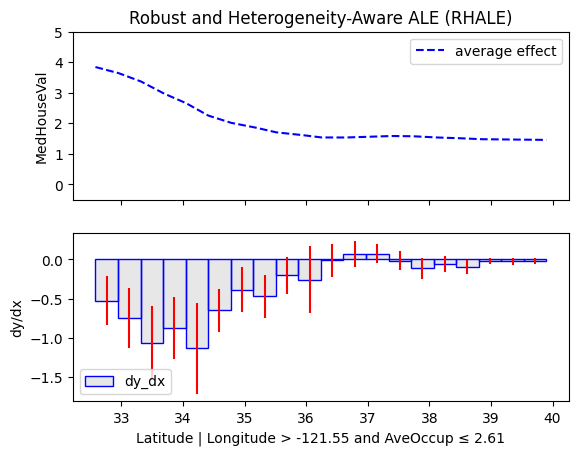

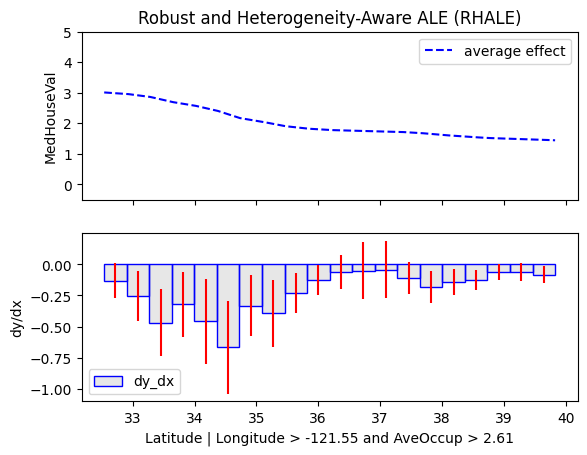

In [55]:
for node_idx in [3, 4]:
    reg_rhale.plot(feature=6, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

**Global Trend:** House prices decrease as we move north.  

**Regional Trends:** Moreorless the same, with minor different curves.

## Longitude (west to east)

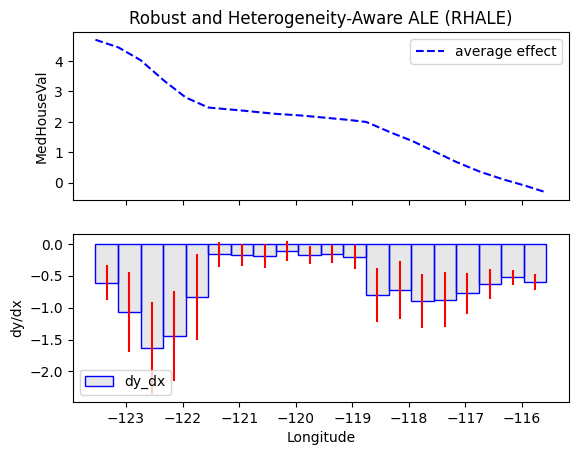

In [56]:
reg_rhale.plot(feature=7, node_idx=0, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

**Global Trend:** House prices decrease as we move east.  

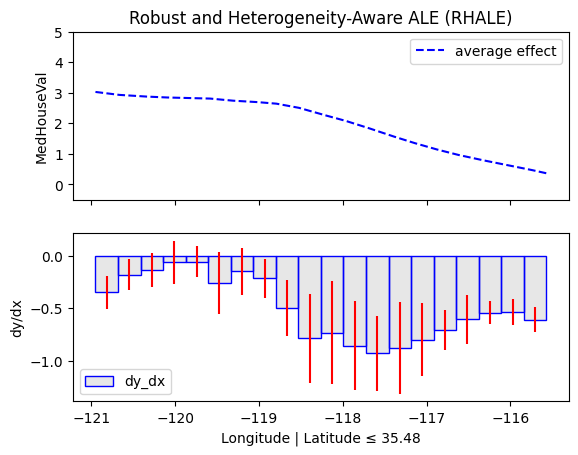

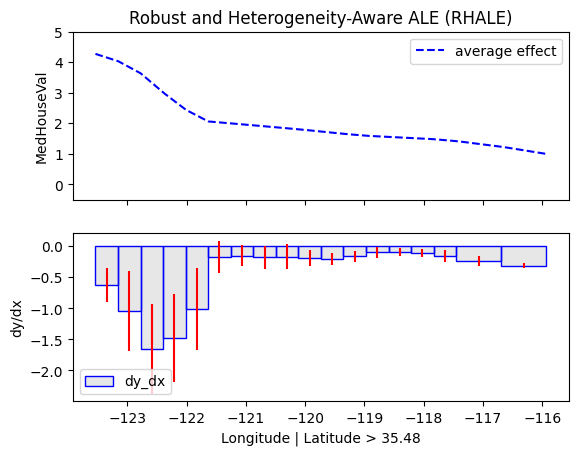

In [57]:
for node_idx in [1, 4]:
    reg_rhale.plot(feature=7, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

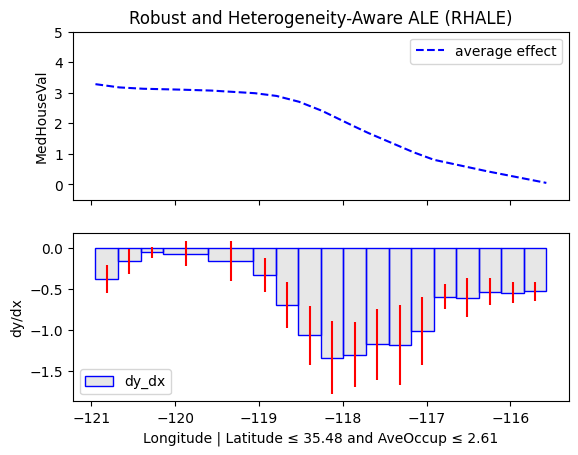

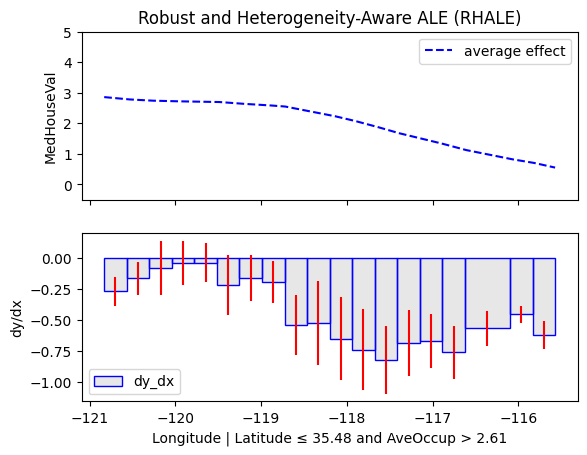

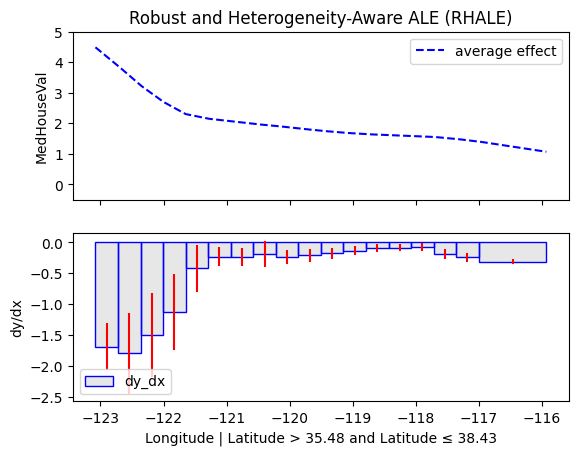

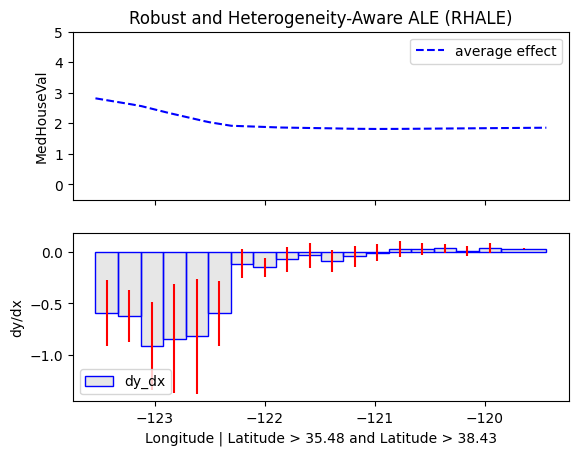

In [58]:
for node_idx in [2, 3, 5, 6]:
    reg_rhale.plot(feature=7, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

**Global Trend:** House prices decrease as we move east.  

**Regional Trends:**  
- **South (latitude <= 35.85):** Prices drop more sharply in the second half from west to east.
  - **AveOccup <= 2.61:** Prices drop even more steeper, suggesting that in less crowded southern areas, housing demand or value drops off more quickly as you move east.
  - **AveOccup > 2.61:** Patterns resemble the broader subregion (latitude <= 35.85), with no significant change in trend.
- **North (latitude > 35.85):** The steepest price decline happens in the western half (closer to the coast).  
  - **Latitude <= 38.43:** The sharp west-to-east price drop remains the same
  - **Latitude > 38.43:** The decline flattens, since the eastern part of far-northern California starts from lower prices